In [1]:
#en.openfoodfacts.org.products.csv

# Contents :
**Part 0 : Environnement Setup**
 - <a href="#C1">Importation of libraries</a>
 - <a href="#C2">Definition of functions</a>
 - <a href="#C3">Dataset Import</a>
 
**Part 1 : Univariate analysis**
 - <a href="#C4">Qualitative variables</a>
 - <a href="#C5">Quantitative variables</a>

**Part 2 : Multivariate analysis**
 - <a href="#C6">Correlation qualitative variables</a>
 - <a href="#C7">Correlation quantitative variables</a>
 - <a href="#C8">Correlation quantitative and qualitative variables</a>
 - <a href="#C9">PCA</a>

# Part 0 : Environnement Setup

# <a name="C1">Importation of libraries</a>

In [2]:
# Import of libraries
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
import statsmodels.api as sm
import datetime as dt
import scipy.stats as st
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

C:\Users\najwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\najwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
# Displaying versions of libraries
print("pandas version : " + pd.__version__)
print("numpy version : " + np.__version__)
print("matplotlib version : " + mp.__version__)
print("seaborn version : " + sns.__version__)

pandas version : 1.4.2
numpy version : 1.21.5
matplotlib version : 3.5.1
seaborn version : 0.11.2


In [4]:
# Making ajustements
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 500)
pd.set_option('display.max_rows', 500)

# <a name="C2">Definition of functions</a>

In [5]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    '''Function specific to PCA'''
    
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # Initialising figure  
            fig, ax = plt.subplots(figsize=(7,6))

            # Determining graph limits
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Displaying arrows
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (check doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # Displaying names of variables
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # Dispalying the circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # Determining graph limits
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # Displaying horizontal et vertical lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Dispalying axix names, percentage of inertia
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Correlations circle (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [6]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Function specific to PCA'''
    
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialising figure       
            fig = plt.figure(figsize=(7,6))
        
            # Displaying points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Displaying labels of points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Determining graph limits
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Displaying horizontal et vertical lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Dispalying axix names, percentage of inertia
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of individuals (on F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [7]:
def display_scree_plot(pca):
    '''Function specific to PCA'''
    
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rank of the axis of inertia")
    plt.ylabel("percentage of inertia")
    plt.title("Equats of eigenvalues")
    plt.show(block=False)

In [8]:
def plot_dendrogram(Z, names):
    '''Function specific to PCA'''
    
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()

# <a name="C3">Dataset Import</a>

In [9]:
# Importinf file
data_or = pd.read_csv('en.openfoodfacts.org.products_nettoye.csv',low_memory=False)

In [10]:
# Copying file
data = data_or.copy() 

In [11]:
# Limiting file to the idea categories
mask = (data['pnns_groups_12']=="Other")
data_idee = data[~mask]
data_idee.shape

(135427, 15)

# Part 1 : Univariate analysis

# <a name="C4">Quantitative Variables</a>

In [12]:
# Identifying the quantitative variables
COL_QUANT = data.select_dtypes(include = ['int32','float64']).columns.tolist()

In [13]:
# Analysing order of magnitude of these variables
data[COL_QUANT].describe()

,nutrition_score,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits_vegetables_nuts_100g
count,460113.000000,444880.000000,562410.000000,562410.000000,562410.000000,562410.000000,562410.000000,562410.000000,562410.000000,562410.000000
mean,9.299457,1126.828418,13.628138,4.343739,27.847697,11.293454,0.767188,8.582160,0.985643,5.516114
std,8.892169,728.570817,15.798571,7.503824,25.087040,18.887656,2.881100,8.721178,4.102033,18.409894
min,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,479.000000,1.800000,0.000000,4.700000,0.000000,0.000000,2.500000,0.000000,0.000000
50%,10.000000,1090.200000,12.340006,0.900000,29.580000,1.900000,0.000000,7.900000,0.150000,0.000000
75%,16.000000,1653.900000,18.000000,5.600000,45.500000,13.000000,0.000000,10.000000,1.010000,0.000000
max,40.000000,3499.270006,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


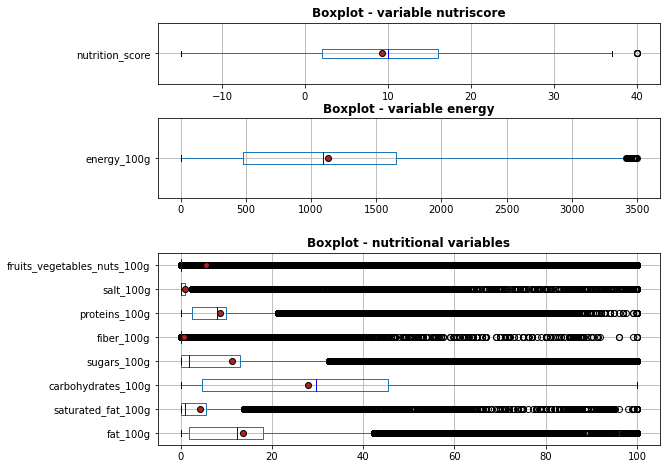

In [14]:
# Analysing order of magnitude of each of these variables
fig = plt.figure(figsize=(9,12))

medianprops = {'color':"blue"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

ax1 = fig.add_subplot(9,1,1)
plt.title('Boxplot - variable nutriscore', fontsize=12,fontweight='bold')
data_nutri = data[[COL_QUANT[0]]]
data_nutri.boxplot(showfliers=True, medianprops=medianprops, 
            vert=False, showmeans=True, meanprops=meanprops, ax=ax1)

ax2 = fig.add_subplot(7,1,2)
plt.title('Boxplot - variable energy', fontsize=12,fontweight='bold')
data_ener = data[[COL_QUANT[1]]]
data_ener.boxplot(showfliers=True, medianprops=medianprops, 
            vert=False, showmeans=True, meanprops=meanprops, ax=ax2)

ax3 = fig.add_subplot(3,1,2)
plt.title('Boxplot - nutritional variables', fontsize=12,fontweight='bold')
sel_cols = COL_QUANT[2:]
data[sel_cols].boxplot(showfliers=True, medianprops=medianprops, 
            vert=False, showmeans=True, meanprops=meanprops, ax=ax3)


plt.show()

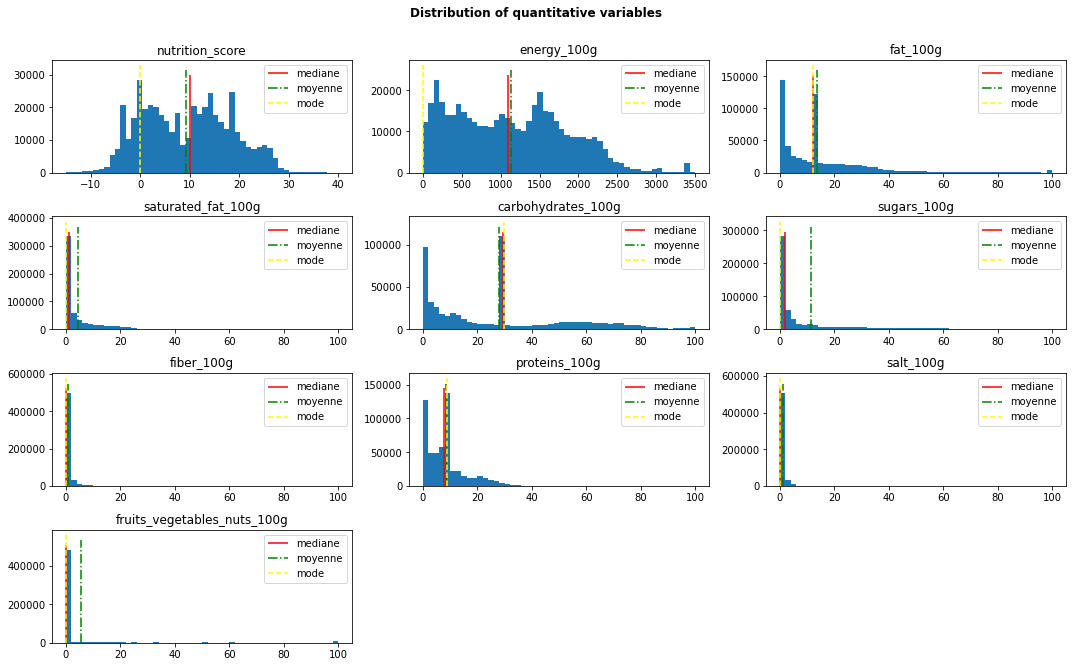

In [15]:
# Analysing order of magnitude of each of these variables
fig = plt.figure(figsize=(15,12))

for i, col in enumerate(COL_QUANT,1):
    ax = fig.add_subplot(5,3,i)
    ax.hist(data[col],  bins=50)
    ax.set_title(col)
    ax.vlines(data[col].median(), *ax.get_ylim(), color='red', ls='-', lw=1.5)
    ax.vlines(data[col].mean(), *ax.get_ylim(),  color='green', ls='-.', lw=1.5)
    ax.vlines(data[col].mode()[0], *ax.get_ylim(), color='yellow', ls='--', lw=1.5)
    ax.legend(['mediane','moyenne','mode'])

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution of quantitative variables', fontsize=12,
             fontweight='bold')


plt.show()

In [16]:
# Displaying skewness and kurtosis for each of these variables
for col in COL_QUANT:
    print(col)
    print("skw:\n",data[col].skew())
    print("kur:\n",data[col].kurtosis())

nutrition_score
skw:
 0.14201140745857968
kur:
 -0.9573833508396294
energy_100g
skw:
 0.3624472503727772
kur:
 -0.5826783029317522
fat_100g
skw:
 2.44220201917536
kur:
 8.421690033853421
saturated_fat_100g
skw:
 3.547735265250204
kur:
 23.084836738130942
carbohydrates_100g
skw:
 0.7383412756156039
kur:
 -0.4466625027704558
sugars_100g
skw:
 2.0797557148229235
kur:
 3.880587948233654
fiber_100g
skw:
 10.754323212191633
kur:
 204.74271188520805
proteins_100g
skw:
 2.96781041857685
kur:
 16.978464426218334
salt_100g
skw:
 16.722878545798263
kur:
 342.62764745405593
fruits_vegetables_nuts_100g
skw:
 3.9199334237095016
kur:
 15.162320260582968


# <a name="C5">Qualitative Variables</a>

In [17]:
# Identifying qualitative variables
COL_QUAL = data.select_dtypes(include = ['object']).columns.tolist()
COL_QUAL

['code', 'product_name', 'pnns_groups_1', 'nutriscore_grade', 'pnns_groups_12']

In [18]:
# Analysing order of magnitude of these variables
data[COL_QUAL].describe()

,code,product_name,pnns_groups_1,nutriscore_grade,pnns_groups_12
count,562410,542074,562410,460113,562410
unique,562410,389373,11,5,6
top,3523680425132,Comté,unknown,d,Other
freq,1,566,262414,138573,426983


In [19]:
# Removing variables not analysed
list = ['code','product_name']
for col in list:
    COL_QUAL.remove(col)
COL_QUAL

['pnns_groups_1', 'nutriscore_grade', 'pnns_groups_12']

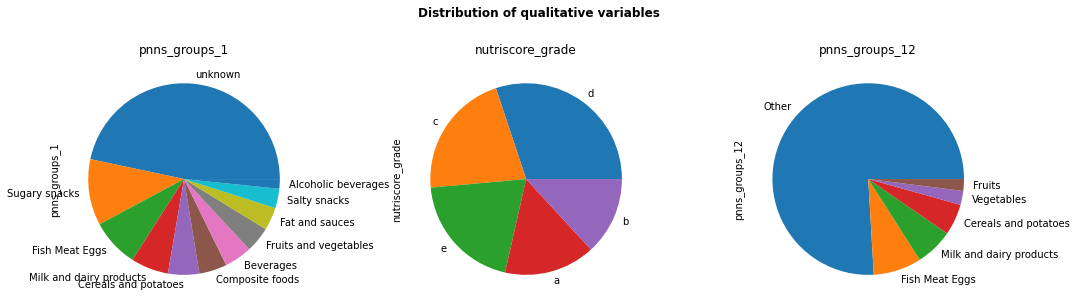

In [20]:
# Analysing order of magnitude of each of these variables
fig = plt.figure(figsize=(15,12))

data_ordered = data.sort_values(by=['nutriscore_grade'])

for i, col in enumerate(COL_QUAL,1):
    ax = fig.add_subplot(3,3,i)
    ax.set_title(col)
    data_ordered[col].value_counts(normalize=True).plot(kind='pie')
    plt.xticks(rotation=45)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution of qualitative variables', fontsize=12,
             fontweight='bold')

plt.show()

# Part 2 : Multivariate analysis

# <a name="C6">Correlation between qualitative variables</a>

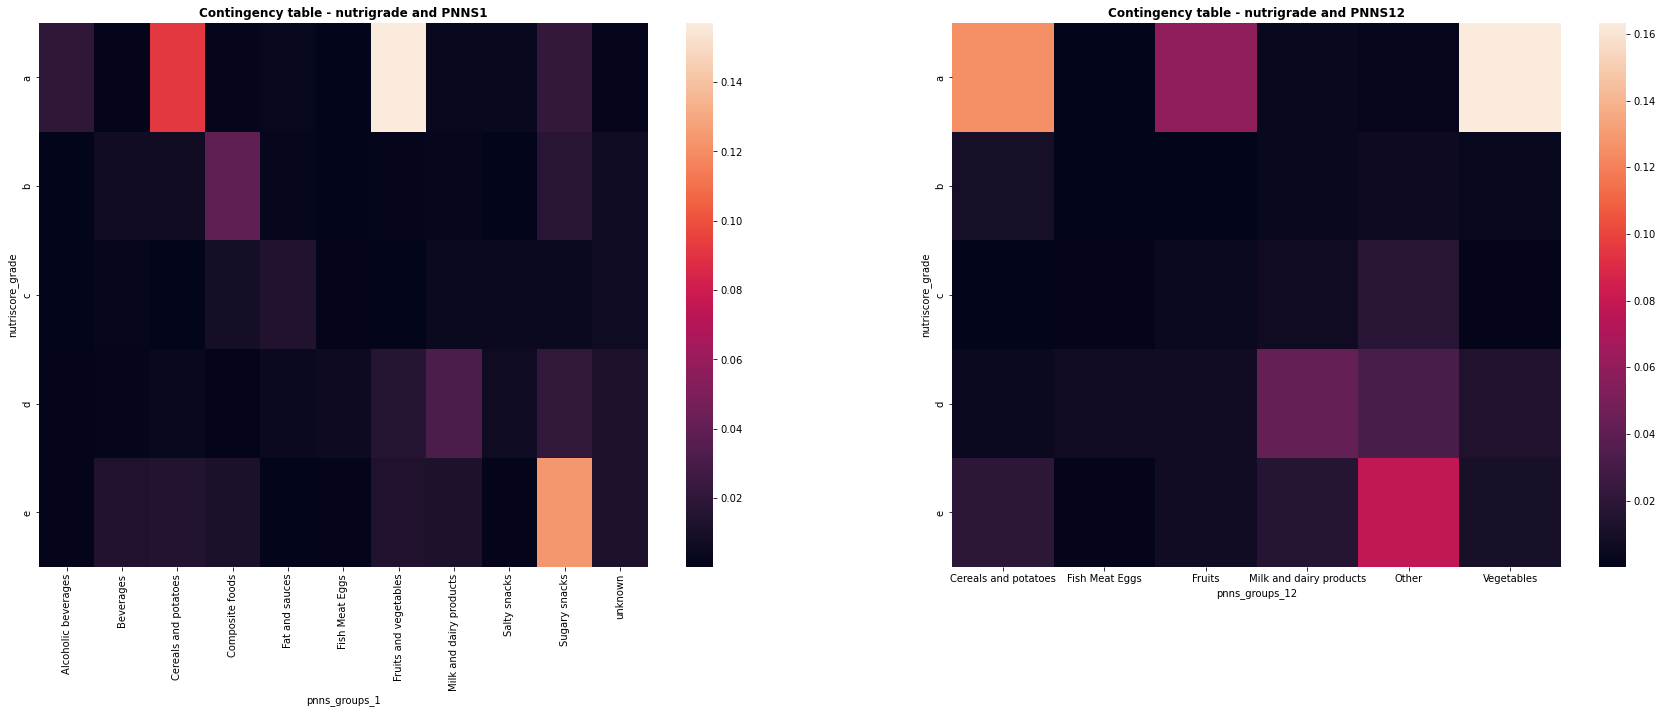

In [21]:
# Checking the proportion of missing values by indicator and year.
plt.figure(figsize = (30,10))

X = COL_QUAL[1]

plt.subplot(1, 2, 1)
plt.title("Contingency table - nutrigrade and PNNS1",fontsize=12,
             fontweight='bold')
Y = COL_QUAL[0]
pivot_table = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
tx = pivot_table.loc[:,["Total"]]
ty = pivot_table.loc[["Total"],:]
n = len(data)
indep = tx.dot(ty) / n
c = pivot_table.fillna(0) 
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1])

plt.subplot(1, 2, 2)
plt.title("Contingency table - nutrigrade and PNNS12",fontsize=12,
             fontweight='bold')
Y = COL_QUAL[2]
pivot_table = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
tx = pivot_table.loc[:,["Total"]]
ty = pivot_table.loc[["Total"],:]
n = len(data)
indep = tx.dot(ty) / n
c = pivot_table.fillna(0) 
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1])

plt.show()

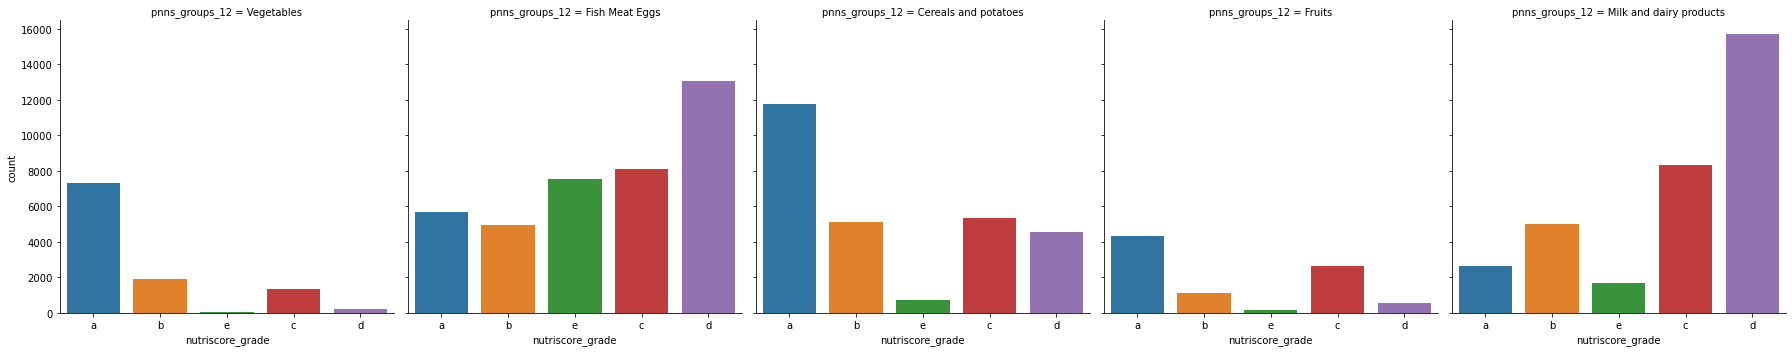

In [22]:
# Checking the "strength" of this correlation in view of the correlation values as the heatmap above shows correlation
# Visualising the relationship between qualitative variables by another method.
sns.catplot(x='nutriscore_grade',
            col='pnns_groups_12',
            kind="count", data=data_idee,
            aspect=1)

# <a name="C7">Correlation between quantitative variables</a>

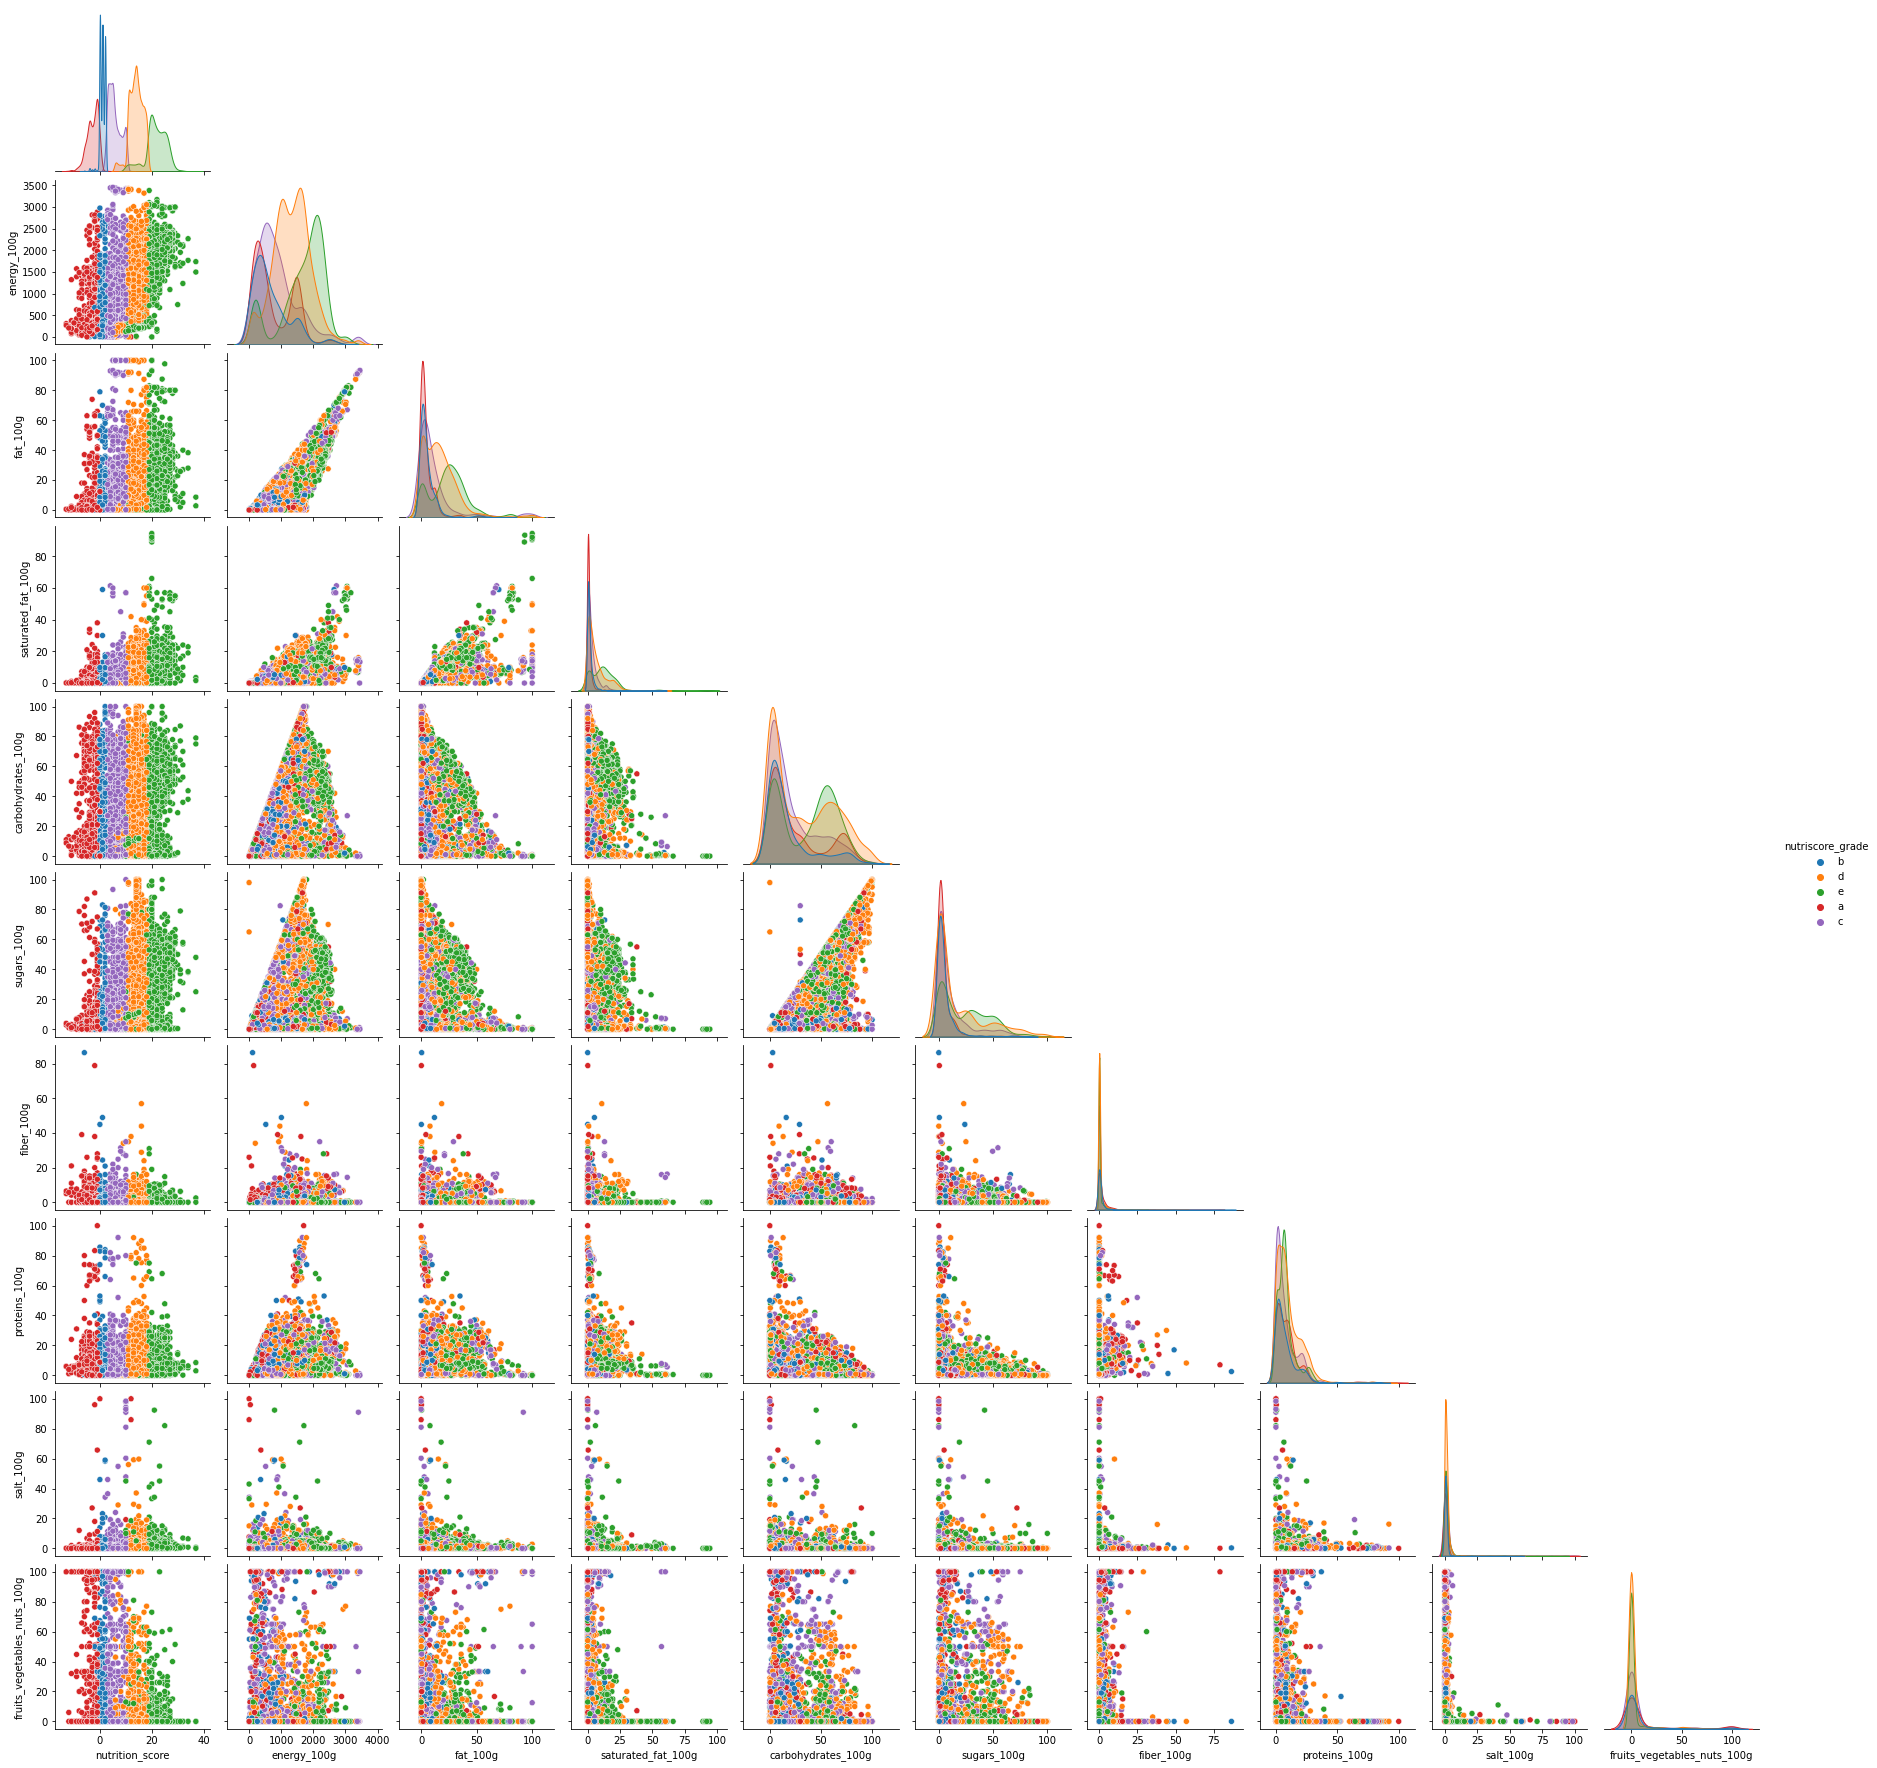

In [23]:
# Correlation between quantitative variables with pairplot
%matplotlib inline
data_sample = data.sample(10000)
s = sns.pairplot(data_sample, hue="nutriscore_grade", corner=True)

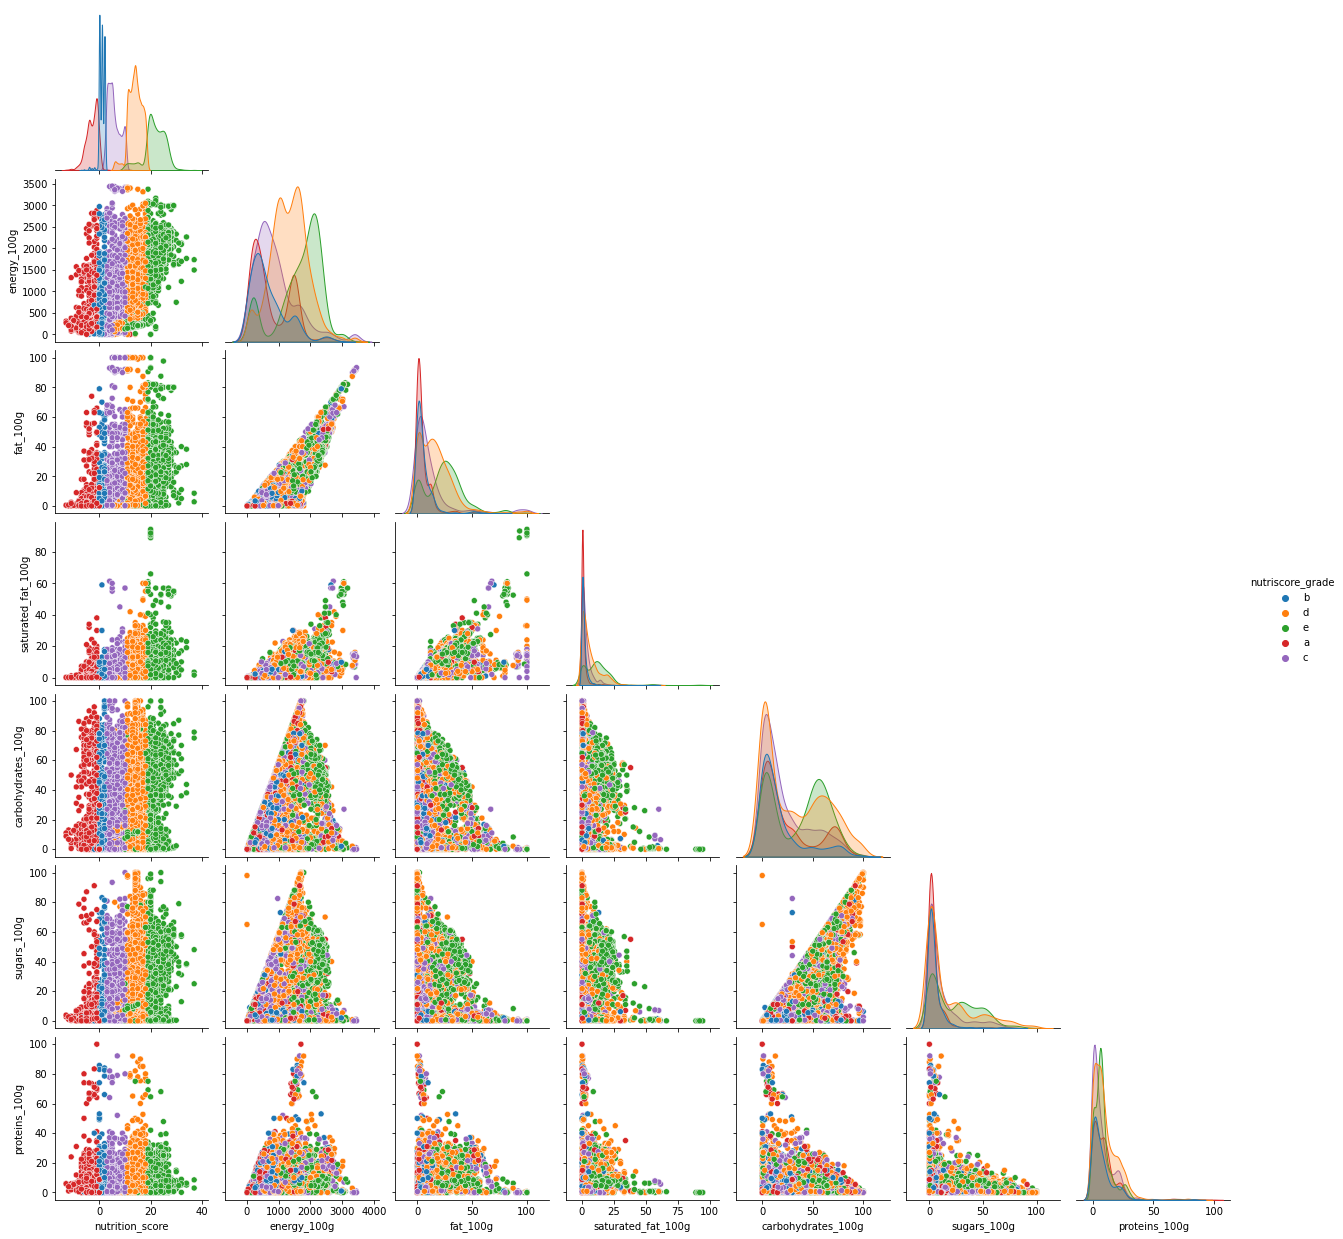

In [24]:
# Removing non correlated variables. From the previous analysis, there is little correlation between nutriscore and fibre, fruit/veg content and salt. 
COL_QUANT.remove('fiber_100g')
COL_QUANT.remove('fruits_vegetables_nuts_100g')
COL_QUANT.remove('salt_100g')
# Correlation between quantitative variables with pairplot
g = sns.pairplot(data_sample, hue='nutriscore_grade', vars=COL_QUANT, corner=True)

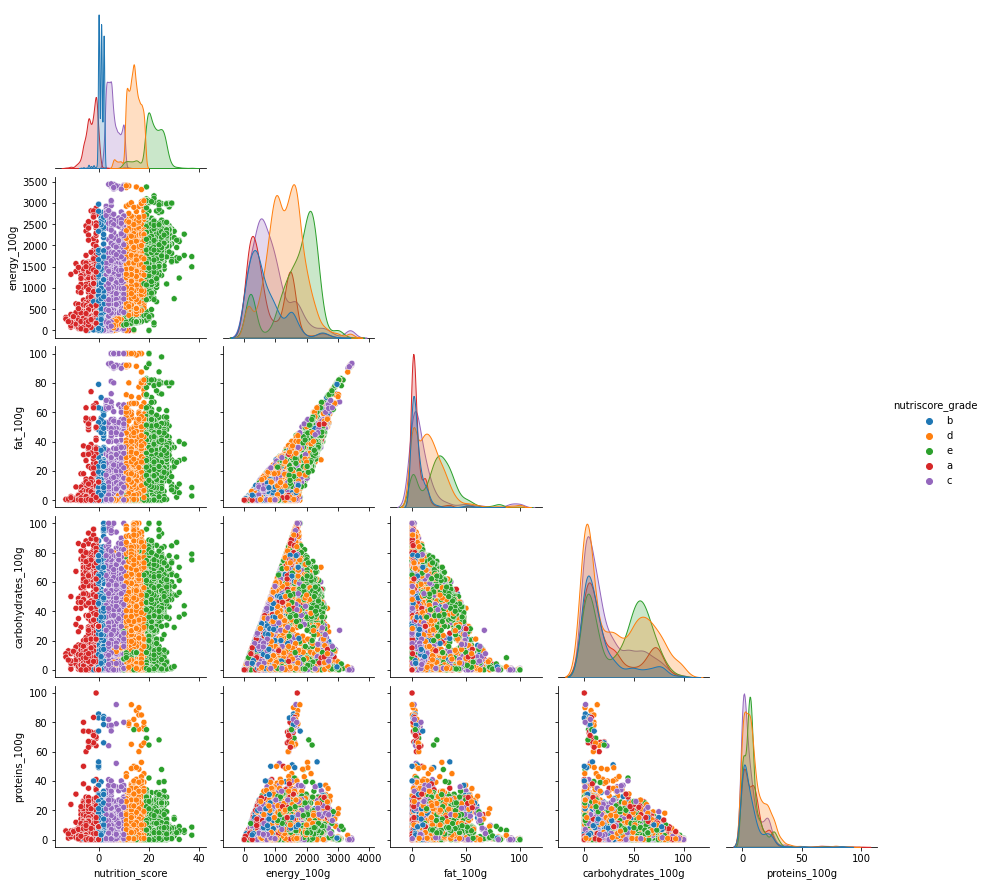

In [25]:
# Correlation between main quantitative variables only with pairplot
g = sns.pairplot(data_sample, hue='nutriscore_grade', vars=['nutrition_score','energy_100g','fat_100g','carbohydrates_100g','proteins_100g'], corner=True)

C:\Users\najwa\AppData\Local\Temp\ipykernel_23476\4027443789.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


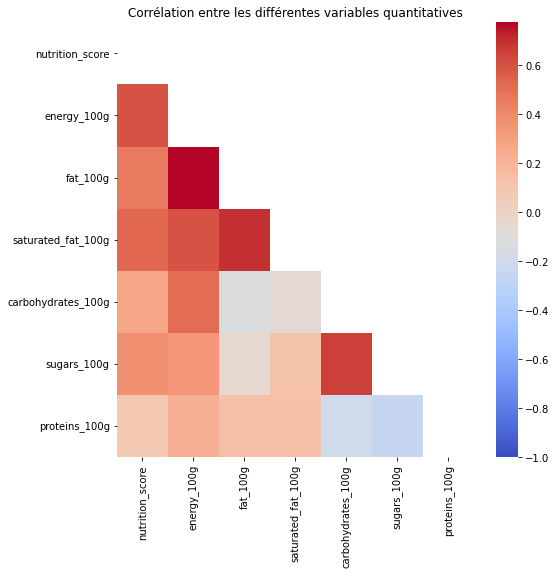

In [26]:
# Heatmap correlation between quantitative variables
plt.figure(figsize=(8,8))
plt.title('Corrélation entre les différentes variables quantitatives', fontsize = 12)

corr = data[COL_QUANT].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True 

ax = sns.heatmap(corr, mask=mask, vmin=-1, cmap='coolwarm')
plt.show()
sns.set(font_scale=1)

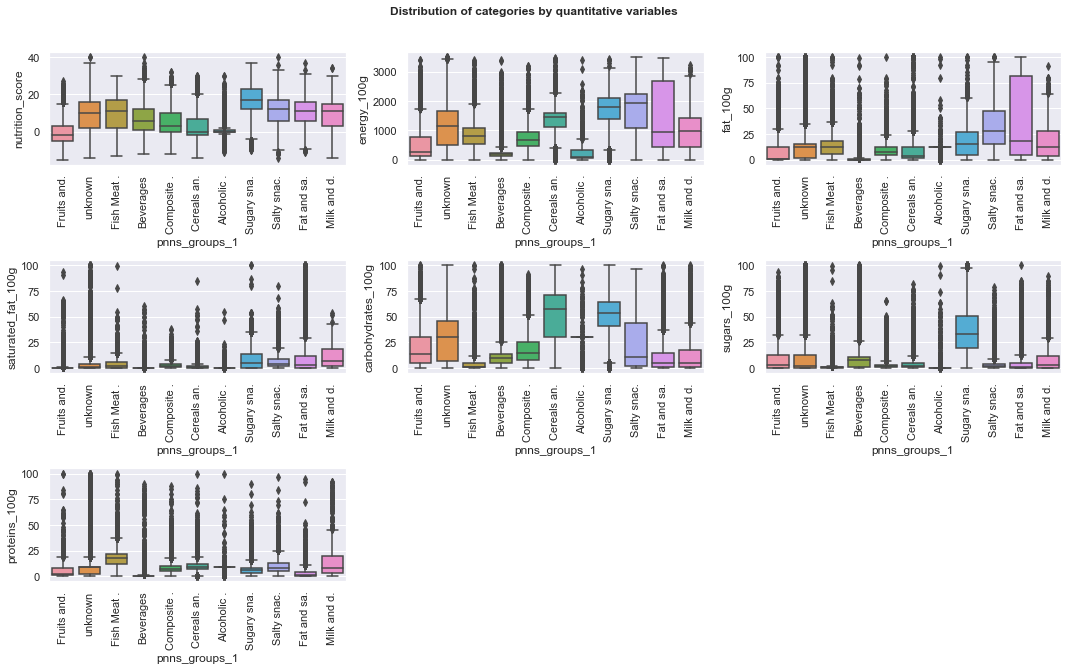

In [27]:
# Visualising boxplot by categories PNNS 1 by nutritional variables (ANOVA)
fig = plt.figure(figsize=(15,15))

for i, c in enumerate(COL_QUANT,1):
    ax = fig.add_subplot(5,3,i)
    sns.boxplot(data=data, x='pnns_groups_1', y=c, ax=ax)
    plt.xticks(rotation=90)
    labels = [item.get_text() for item in ax.get_xticklabels()]
    short_labels = [s[0:10]+'.' if len(s)>10 else s for s in labels]
    ax.axes.set_xticklabels(short_labels)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
#plt.tight_layout()
plt.suptitle('Distribution of categories by quantitative variables', fontsize=12,
             fontweight='bold')
plt.show()

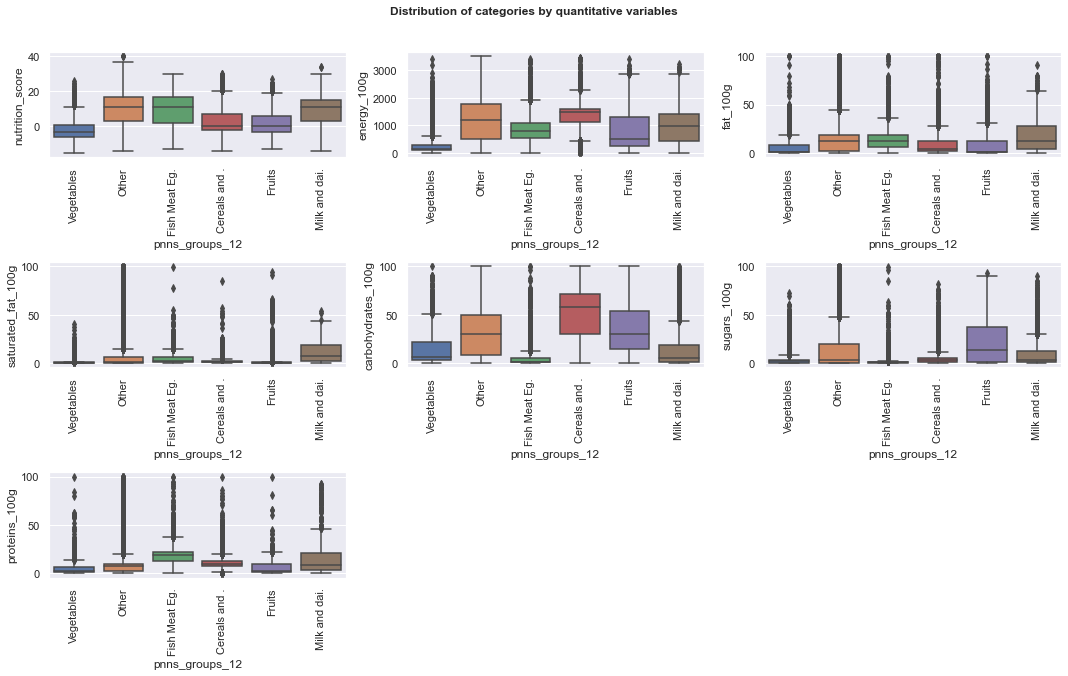

In [28]:
# Visualising boxplot by categories PNNS 12 by nutritional variables (ANOVA)
fig = plt.figure(figsize=(15,15))

for i, c in enumerate(COL_QUANT,1):
    ax = fig.add_subplot(5,3,i)
    sns.boxplot(data=data, x='pnns_groups_12', y=c, ax=ax)
    plt.xticks(rotation=90)
    labels = [item.get_text() for item in ax.get_xticklabels()]
    short_labels = [s[0:12]+'.' if len(s)>12 else s for s in labels]
    ax.axes.set_xticklabels(short_labels)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution of categories by quantitative variables', fontsize=12,
             fontweight='bold')
plt.show()

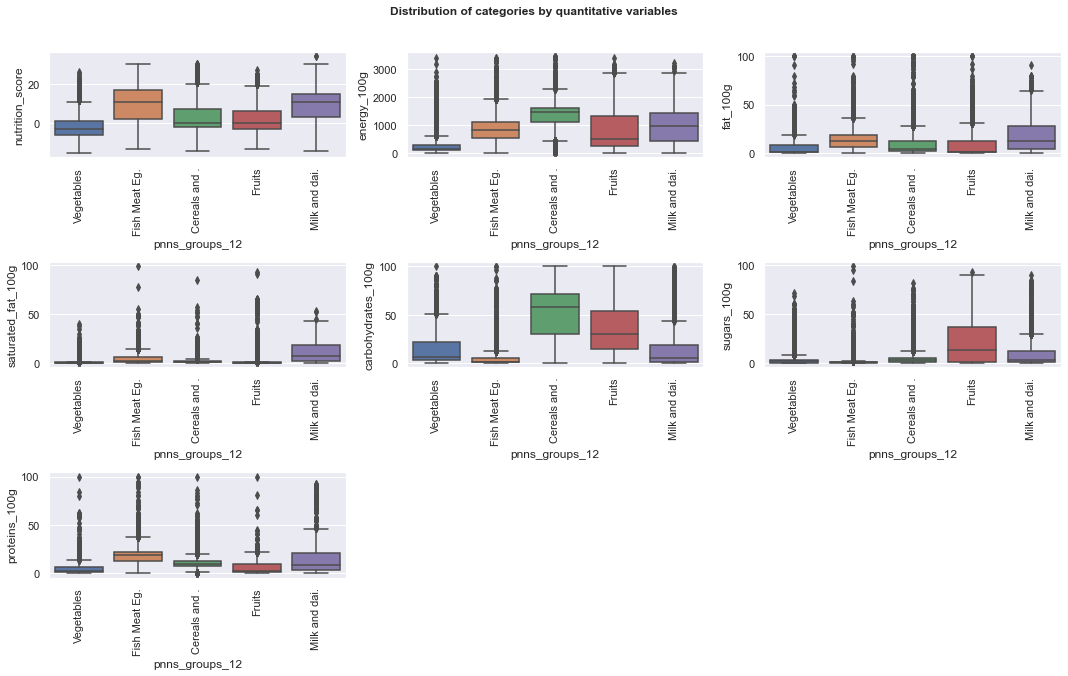

In [29]:
# Visualising boxplot by categories PNNS 12 without Other category by nutritional variables (ANOVA)
fig = plt.figure(figsize=(15,15))

for i, c in enumerate(COL_QUANT,1):
    ax = fig.add_subplot(5,3,i)
    sns.boxplot(data=data_idee, x='pnns_groups_12', y=c, ax=ax)
    plt.xticks(rotation=90)
    labels = [item.get_text() for item in ax.get_xticklabels()]
    short_labels = [s[0:12]+'.' if len(s)>12 else s for s in labels]
    ax.axes.set_xticklabels(short_labels)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution of categories by quantitative variables', fontsize=12,
             fontweight='bold')
plt.show()

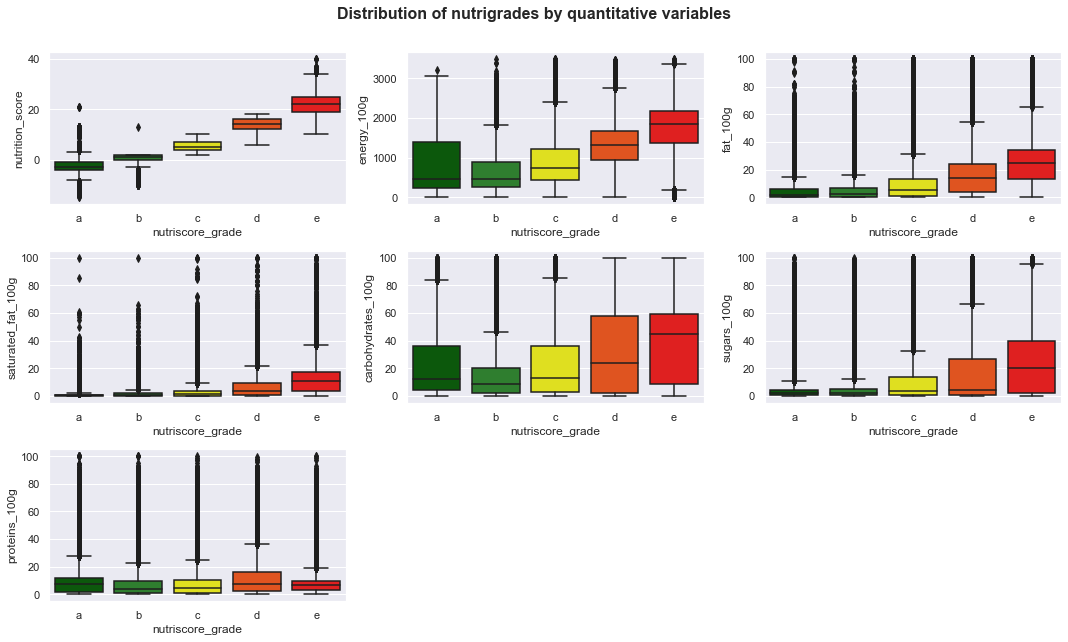

In [30]:
# Visualising boxplot by nutrigrade by nutritional variables (ANOVA)
nutri_pal = ['darkgreen', 'forestgreen', 'yellow', 'orangered', 'red']

fig = plt.figure(figsize=(15,15))
with sns.color_palette(nutri_pal):
    for i, col in enumerate(COL_QUANT,1):
        ax = fig.add_subplot(5,3,i)
        order = ["a", "b", "c", "d", "e"]
        sns.boxplot(data=data, x="nutriscore_grade", y=col, order=order, ax=ax)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution of nutrigrades by quantitative variables', fontsize=16,
             fontweight='bold')

plt.show()


# <a name="C9">PCA</a>

In [31]:
# Removing nutriscore from COL_QUANT
COL_QUANT.remove('nutrition_score')
COL_QUANT

['energy_100g',
 'fat_100g',
 'saturated_fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'proteins_100g']

C:\Users\najwa\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


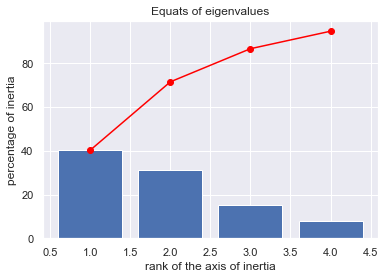

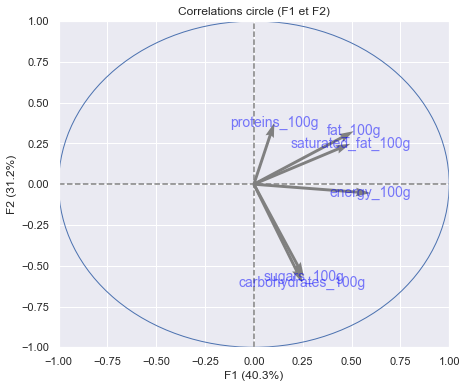

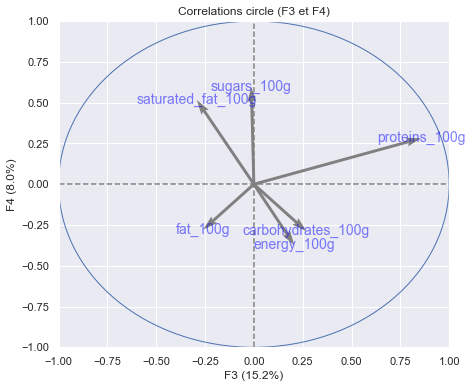

In [32]:
# Displaying the PCA 
# Chosing 4 components to compute
n_comp = 4

# Selecting columns to consider for PCA
acp_vars = COL_QUANT

data_pca = data[acp_vars]
data_pca = data_pca.fillna(data_pca.mean())

# Preparing data for PCA
X = data_pca.values
names = data_pca.index 
features = data_pca.columns

# Centering and reducing
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(data_pca[acp_vars])

# Computing main components 
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Decomposing eigenvalues
display_scree_plot(pca)

# Displaying circle of correlations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

plt.show()

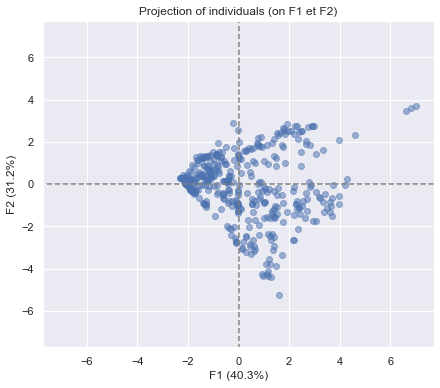

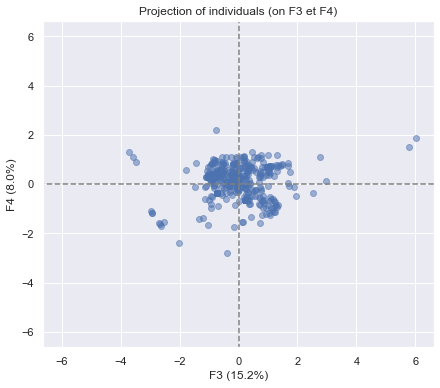

In [33]:
# Projecting individuals
X_projected = pca.transform(X_scaled)
X_sampled = X_projected[np.random.choice(X_projected.shape[0], 500, replace=False)]
display_factorial_planes(X_sampled, n_comp, pca, [(0,1),(2,3)], alpha=.5)
plt.show()

The End of Exploration